In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import sys
sys.path.append(r'C:\Users\justink\Code\dro')

import dro.utilities as dro
import dro.plotting_functions as dro_plots

failed to import CV2 in core.utilities


c:\users\justink\code\imaging_behavior\imaging_behavior\core\tifffile.py:278: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "


failed to import mask in core.jcamdata.py
failed to import get_mask_dict_gui in core.epoch.py
FreeType import Failed: Freetype library not found
failed to import mask relalated functions in __init__.py


## Load data

In [2]:
datapath = r'C:\Users\justink\Documents\ExploringBehavior\data'
df = dro.load_from_folder(datapath)

Loading C:\Users\justink\Documents\ExploringBehavior\data\161019082828-task=DetectionOfChange_Gratings_stage=2_LickDetectTraining_mouse=M261584.pkl
Loading C:\Users\justink\Documents\ExploringBehavior\data\161019083139-task=DetectionOfChange_Gratings_stage=2_LickDetectTraining_mouse=M258275.pkl
Loading C:\Users\justink\Documents\ExploringBehavior\data\161019083147-task=DetectionOfChange_Gratings_stage=2_LickDetectTraining_mouse=M258274.pkl
Loading C:\Users\justink\Documents\ExploringBehavior\data\161019083559-task=DetectionOfChange_Gratings_stage=2_LickDetectTraining_mouse=M258089.pkl
Loading C:\Users\justink\Documents\ExploringBehavior\data\161019090208-task=DetectionOfChange_Gratings_stage=2_LickDetectTraining_mouse=M258173.pkl
Loading C:\Users\justink\Documents\ExploringBehavior\data\161019090343-task=DetectionOfChange_Gratings_stage=2_LickDetectTraining_mouse=M258276.pkl
Loading C:\Users\justink\Documents\ExploringBehavior\data\161019092145-task=DetectionOfChange_Gratings_stage=2_L

In [3]:
cohort = {
    'Cohort 1': ['M246782', 'M249123', 'M258174', 'M250783', 'M250786','M258196'],
    'Cohort 2': ['M258173', 'M258089', 'M258276', 'M261584', 'M258274','M258275'],
    'Cohort 3': ['M272465','M265158','M271966','M265154','M258194','M265166'],
}

In [4]:
cohort_assignment = []
for c,m_list in cohort.iteritems():
    for m in m_list:
        print c,m
        cohort_assignment.append(
            dict(
                cohort=c,
                mouse_id=m,
            )
        )
cohort_assignment = pd.DataFrame(cohort_assignment)

Cohort 3 M272465
Cohort 3 M265158
Cohort 3 M271966
Cohort 3 M265154
Cohort 3 M258194
Cohort 3 M265166
Cohort 2 M258173
Cohort 2 M258089
Cohort 2 M258276
Cohort 2 M261584
Cohort 2 M258274
Cohort 2 M258275
Cohort 1 M246782
Cohort 1 M249123
Cohort 1 M258174
Cohort 1 M250783
Cohort 1 M250786
Cohort 1 M258196


In [5]:
df = df.merge(
    cohort_assignment,
    how='left',
    on='mouse_id',
)

In [6]:
## identify training day

trim = np.vectorize(lambda x: x[:10])

training_day_lookup = {}

for key, group in df.groupby(['mouse_id',]):
    dates = np.sort(trim(group['startdatetime'].unique().astype(str)))
    
    training_day_lookup[key] = {date:training_day for training_day,date in enumerate(dates)}

df['date'] = df['startdatetime'].map(lambda x: str(x)[:10])
df['training_day'] = df.apply(lambda row: training_day_lookup[row['mouse_id']][row['date']],axis=1)
df['day_of_week'] = df.startdatetime.dt.weekday_name

## build arrays for change detection

df['change'] = df['trial_type']=='go'
df['detect'] = df['response']==1.0

## calculate reaction times

df['reaction_time'] = df['lick_times'].map(lambda x: x[0] if len(x)>0 else np.nan)
df['reaction_time'] = df.apply(lambda row: row['reaction_time'] - row['change_time'],axis=1)

## unwrap the response window
df['response_window_lower'] = df['response_window'].map(lambda x: x[0])
df['response_window_upper'] = df['response_window'].map(lambda x: x[1])


In [7]:
## sklearn-style discrimination metrics

import numpy as np
from sklearn import metrics
from scipy import stats

def d_prime(y_true,y_pred,eps=None):

    C = metrics.confusion_matrix(y_true,y_pred).astype(float) 
    
    try:
        tn, fp, fn, tp = C.ravel()

        HR = tp / (tp + fn)
        FAR = fp / (tn + fp)

        if eps is None:
            # a reasonable minimum value is 1 / sum of trials
            eps = 1.0/C.sum()

        HR = max(HR,eps)
        HR = min(HR,1.0-eps)

        FAR = max(FAR,eps)
        FAR = min(FAR,1.0-eps)

        return stats.norm.ppf(HR) - stats.norm.ppf(FAR)
    except ValueError:
        return np.nan

def discrim_p(y_true,y_pred):

    C = metrics.confusion_matrix(y_true,y_pred)
    
    try:
        return stats.chi2_contingency(C)[1]
    except ValueError:
        return 1.0
    
# change detection metrics

def _trial_types_mask(trial_types,behav_df):
    
    if trial_types is not None and len(trial_types)>0:
        return behav_df['trial_type'].isin(trial_types)
    else:
        return np.ones((len(behav_df),),dtype=bool)
    
def discrim(behav_df,change,detect,trial_types=('go','catch'),metric=None,metric_kws=None):
    
    if metric is None:
        metric = d_prime
    
    if metric_kws is None:
        metric_kws = dict()
        
    mask = _trial_types_mask(trial_types,behav_df)
        
    y_true = behav_df[mask]['change']
    y_pred = behav_df[mask]['detect']
        
    return metric(y_true,y_pred,**metric_kws)

def response_bias(behav_df,detect,trial_types=('go','catch')):
    mask = _trial_types_mask(trial_types,behav_df)
    
    return behav_df[mask][detect].mean()

def num_trials(behav_df):
    return len(behav_df)

def reaction_times(behav_df,percentile=50,trial_types=('go',)):
    """
    reaction times to GO trials
    
    """
    mask = _trial_types_mask(trial_types,behav_df)
    quantile = behav_df[mask]['reaction_time'].dropna().quantile(percentile/100.0)
    
    return quantile

def total_water(behav_df,trial_types=()):
    
    mask = _trial_types_mask(trial_types,behav_df)
    
    return behav_df[mask][(behav_df['reward_times'].map(len)>0)]['reward_volume'].sum()

def earned_water(behav_df):
    
    return total_water(behav_df,('go',))

In [8]:
def compute_metrics(group):
    result = {
        'd-prime': discrim(group,'change','detect',metric=d_prime),
        'discrim_p': discrim(group,'change','detect',metric=discrim_p),
        'response_bias': response_bias(group,'detect'),
        'earned_water': earned_water(group), 
        'total_water': total_water(group), 
        'num_trials': num_trials(group),
        'reaction_time_50th%ile': reaction_times(group,percentile=50),
        'reaction_time_05th%ile': reaction_times(group,percentile=5),
        'reaction_time_95th%ile': reaction_times(group,percentile=95),
    }
    
    return pd.Series(result, name='metrics')

water = df.groupby(['cohort','mouse_id','training_day']).apply(compute_metrics).reset_index()
water['frac_earned_water'] = water['earned_water'] / water['total_water']
water['reaction_time_spread'] = water['reaction_time_95th%ile'] - water['reaction_time_05th%ile']
water.head()

C:\Users\justink\AppData\Local\Continuum\Anaconda2\envs\dro\lib\site-packages\ipykernel\__main__.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


metrics,cohort,mouse_id,training_day,d-prime,discrim_p,earned_water,num_trials,reaction_time_05th%ile,reaction_time_50th%ile,reaction_time_95th%ile,response_bias,total_water,frac_earned_water,reaction_time_spread
0,Cohort 1,M246782,0,NaN,1.000000,0.000,157.0,NaN,NaN,NaN,NaN,1.092,0.000000,NaN
1,Cohort 1,M246782,1,-0.103298,0.932565,0.306,1563.0,0.148093,1.302331,4.174820,0.160920,0.354,0.864407,4.026726
2,Cohort 1,M246782,2,-0.847842,0.060912,0.132,394.0,0.202361,1.369161,5.315562,0.264151,0.198,0.666667,5.113201
3,Cohort 1,M246782,3,-0.042514,0.814292,0.174,426.0,0.078129,1.488042,4.514744,0.189349,0.276,0.630435,4.436615
4,Cohort 1,M246782,4,-0.360547,0.499528,0.390,423.0,0.172509,1.553026,4.649878,0.266667,0.530,0.735849,4.477369


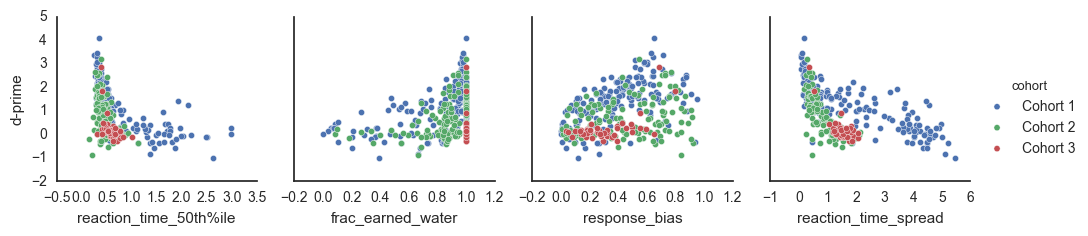

In [9]:
sns.pairplot(data=water,
             hue='cohort',
             y_vars=['d-prime',],
             x_vars=['reaction_time_50th%ile','frac_earned_water','response_bias','reaction_time_spread'],
            )

In [10]:
def stars(p,ns='n.s.'):
    '''Converts p-values into R-styled stars.
    Signif. codes:
        '***' :  < 0.001
        '**' : < 0.01
        '*' : < 0.05
        '.' : < 0.1
        'n.s.' : < 1.0
    '''
#     if p < 0.001:
#         return '***'
#     elif p < 0.01:
#         return '**'
#     el
    if p < 0.05:
        return '*'
    elif p < 0.1:
        return '.'
    else:
        return ns

def plot_stars(p,x,y,ax,ns='n.s.',size='large',horizontalalignment='center',**kwargs):
    ''' Plots significance stars '''
    ax.text(x,y,stars(p,ns),size=size,horizontalalignment=horizontalalignment,**kwargs)

def plot_linestar(p,x1,x2,y,ax):
    ax.hlines(y, x1, x2)
    plot_stars(0.5*(x1+x2),y+0.02,stars(p),ax=ax,size='large',horizontalalignment='center')

In [11]:
class RisingEdge():
    """
    This object implements a "rising edge" detector on a boolean array.
    
    It takes advantage of how pandas applies functions in order.
    
    For example, if the "criteria" column in the `df` dataframe consists of booleans indicating
    whether the row meets a criterion, we can detect the first run of three rows above criterion
    with the following
    
        first_run_of_three = (
            df['criteria']
            .rolling(center=False,window=3)
            .apply(func=RisingEdge().check)
            )
    
    ```
    
    """
    def __init__(self):
        self.firstall = False
    def check(self,arr):
        if arr.all():
            self.firstall = True
        return self.firstall

In [12]:
pdf = water
pdf['d_prime'] = pdf['d-prime']
pdf['stimulus_control'] = pdf['discrim_p'] < 0.01

In [13]:

num_tr_thresh = 50
dprime_thresh = 0.5

consecutive_sessions = 2

pdf['criteria'] = (
    pdf['stimulus_control']
    & (pdf['num_trials'] > num_tr_thresh)
    & (pdf['d-prime'] > dprime_thresh)
)

mask = pdf.num_trials > num_tr_thresh # ignore sessions with very few trials

first = {}

for key, group in pdf.set_index('training_day').sort_index().groupby(['cohort','mouse_id']):
#     print group.head()
    learned = (
        group['criteria']
        .rolling(center=False,window=consecutive_sessions)
        .apply(func=RisingEdge().check)
        )
    summary = pd.DataFrame(
        [learned.rename('learned'),
         group['stimulus_control'],
         group['d_prime'],
         group['num_trials'],
        ]).transpose()
    
    try:
        first_session = summary['learned'][summary['learned']==1.0].index[0]
    except IndexError:
        first_session = np.nan
    
    print key, first_session
#     print summary.tail()
    
    first[key[1]]=first_session

('Cohort 1', 'M246782') 19
('Cohort 1', 'M249123') nan
('Cohort 1', 'M250783') 9
('Cohort 1', 'M250786') 9
('Cohort 1', 'M258174') 4
('Cohort 1', 'M258196') 8
('Cohort 2', 'M258089') 11
('Cohort 2', 'M258173') 22
('Cohort 2', 'M258274') 5
('Cohort 2', 'M258275') 8
('Cohort 2', 'M258276') nan
('Cohort 2', 'M261584') 10
('Cohort 3', 'M258194') 6
('Cohort 3', 'M265154') nan
('Cohort 3', 'M265158') nan
('Cohort 3', 'M265166') nan
('Cohort 3', 'M271966') nan
('Cohort 3', 'M272465') nan


M246782
M249123
M258174
M250783
M250786
M258196
M258173
M258089
M258276
M261584
M258274
M258275
M272465
M265158
M271966
M265154
M258194
M265166


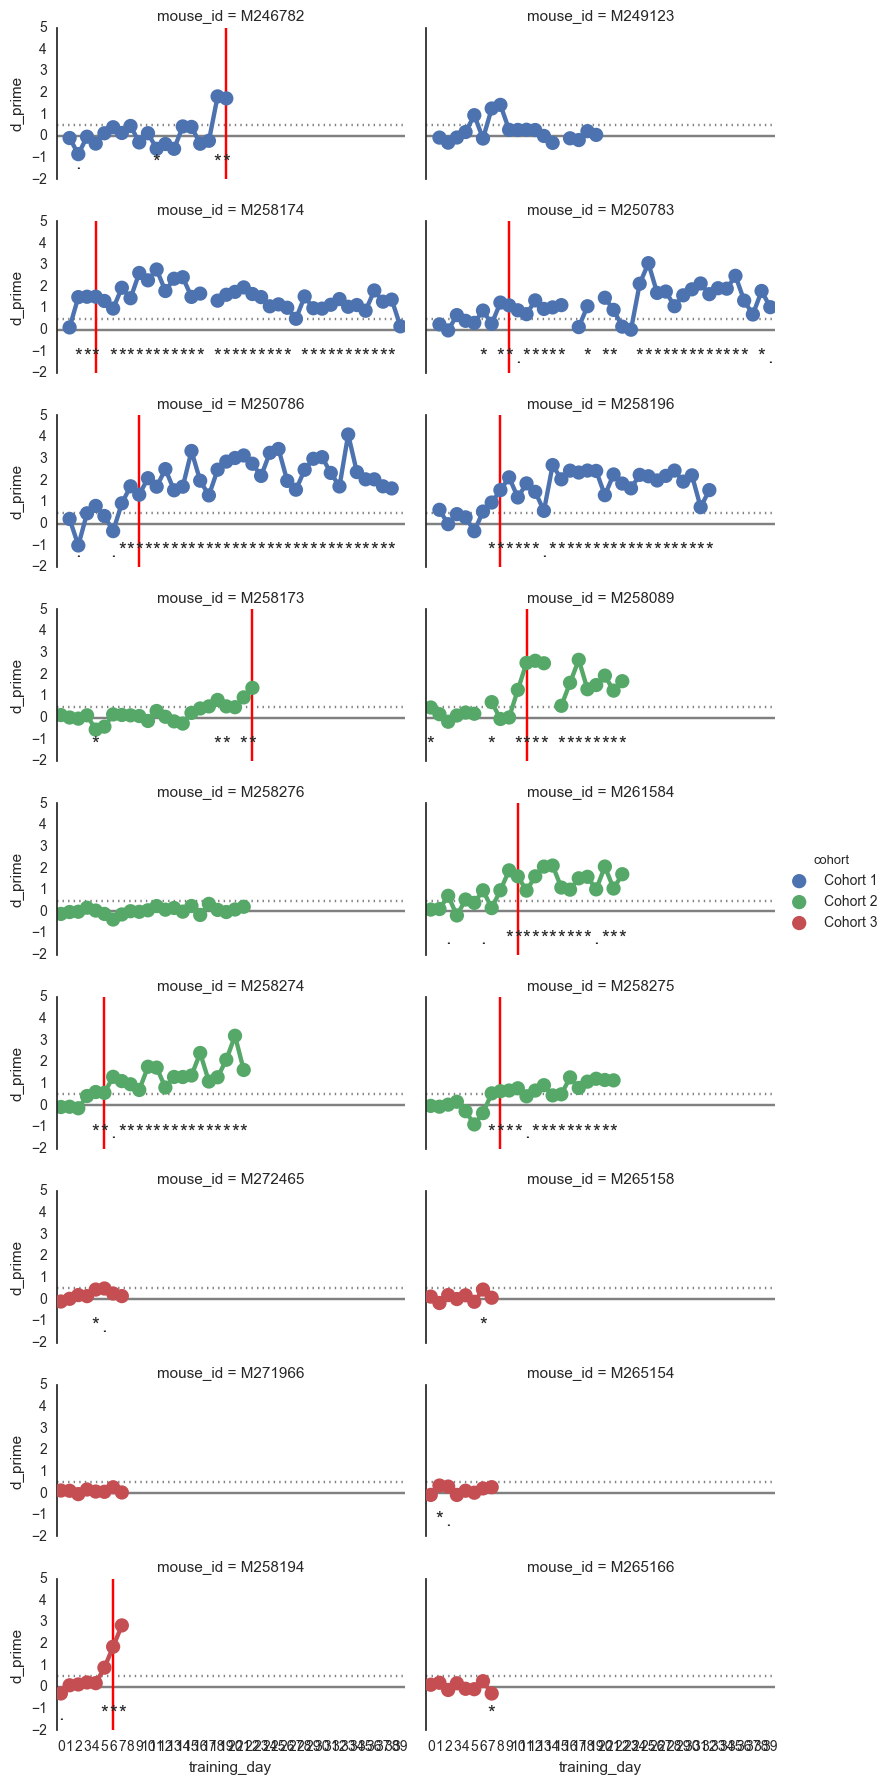

In [14]:
col_order = cohort['Cohort 1'] + cohort['Cohort 2'] + cohort['Cohort 3']

mask = pdf.num_trials > num_tr_thresh # ignore sessions with very few trials

fp = sns.factorplot('training_day','d_prime',data=pdf[mask],
                    col='mouse_id',
                    col_wrap=2,
                    size=2,
                    aspect=2,
                    hue='cohort',
                    col_order=col_order,
              )

yloc = -1.5

for ax,mouse_id in zip(fp.axes.ravel(),col_order):
    ax.axhline(0.0,color='0.5',zorder=-1)
    ax.axhline(dprime_thresh,linestyle=':',color='0.5',zorder=-1)
    print mouse_id
    for r,row in pdf[mask & (pdf['mouse_id']==mouse_id)].iterrows():
        p, x = row['discrim_p'], row['training_day']
        plot_stars(p,x,yloc,ax,ns='')
    ax.axvline(first[mouse_id],color='r',zorder=-1)
    
sns.despine(bottom=True)

In [15]:
def rectify_angle(angle):
    angle = angle % 180
    return abs(min(
        angle,
        180 - angle
    ))

In [16]:
df['orientation_delta'] = df['change_ori'] - df['initial_ori']
df['orientation_delta'] = df['orientation_delta'].map(rectify_angle)

In [17]:
for key,group in df.groupby(['mouse_id','training_day']):
    mask = group['trial_type'].isin(['go','catch'])
    print group[mask]['orientation_delta'].unique()

[]
[ 90.   0.]
[ 90.   0.]
[  0.  90.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[  0.  90.]
[ 90.   0.]
[  0.  90.]
[  0.  90.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[  0.  90.]
[  0.  90.]
[  0.  90.]
[  0.  90.]
[ 90.   0.]
[  0.  90.]
[]
[  0.  90.]
[ 90.   0.]
[  0.  90.]
[  0.  90.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[  0.  90.]
[  0.  90.]
[  0.  90.]
[  0.  90.]
[  0.  90.]
[ 90.   0.]
[  0.  90.]
[  0.  90.]
[ 90.   0.]
[  0.  90.]
[  0.  90.]
[]
[  0.  90.]
[  0.  90.]
[ 90.   0.]
[  0.  90.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[  0.  90.]
[  0.  90.]
[ 90.   0.]
[  0.  90.]
[  0.  90.]
[ 90.   0.]
[  0.  90.]
[  0.  90.]
[  0.  90.]
[  0.  90.]
[]
[  0.  90.]
[  0.  90.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[]
[  0.  90.]
[  0.  90.]
[  0.  90.]
[ 90.   0.]
[  0.  90.]
[ 90.   0.]
[ 90.   0.]
[ 90.   0.]
[

In [18]:
import numpy as np

In [19]:
class LastWaterTime():
    """
    
    """
    def __init__(self):
        self.last_time = {}
    def check(self,row):
        key = (row['mouse_id'],row['training_day'])
        
        # first let's hang on to the last time to return later
        try:
            last_time = self.last_time[key]
        except KeyError:
            self.last_time[key] = np.nan
            last_time = self.last_time[key]
        
        # if they were rewarded this time, let's update the value
        if len(row['reward_times'])>0:
            self.last_time[key] = row['starttime']
            
        # now we return the old value
        return last_time

In [20]:
df.sort_values('starttime',inplace=True)
df['last_water_time'] = df.apply(LastWaterTime().check,axis=1)

In [21]:
df['wait_time'] = df['lick_times'].map(lambda x: x[0] if len(x)>0 else None) - df['starttime']
df['time_since_last_water'] = df['starttime'] - df['last_water_time']

In [22]:
df['time_since_last_water_log'] = df['time_since_last_water'].map(np.log10)

In [23]:
good_mouse = 'M258274'

In [30]:
data.starttime.min()

0.020996164530515671

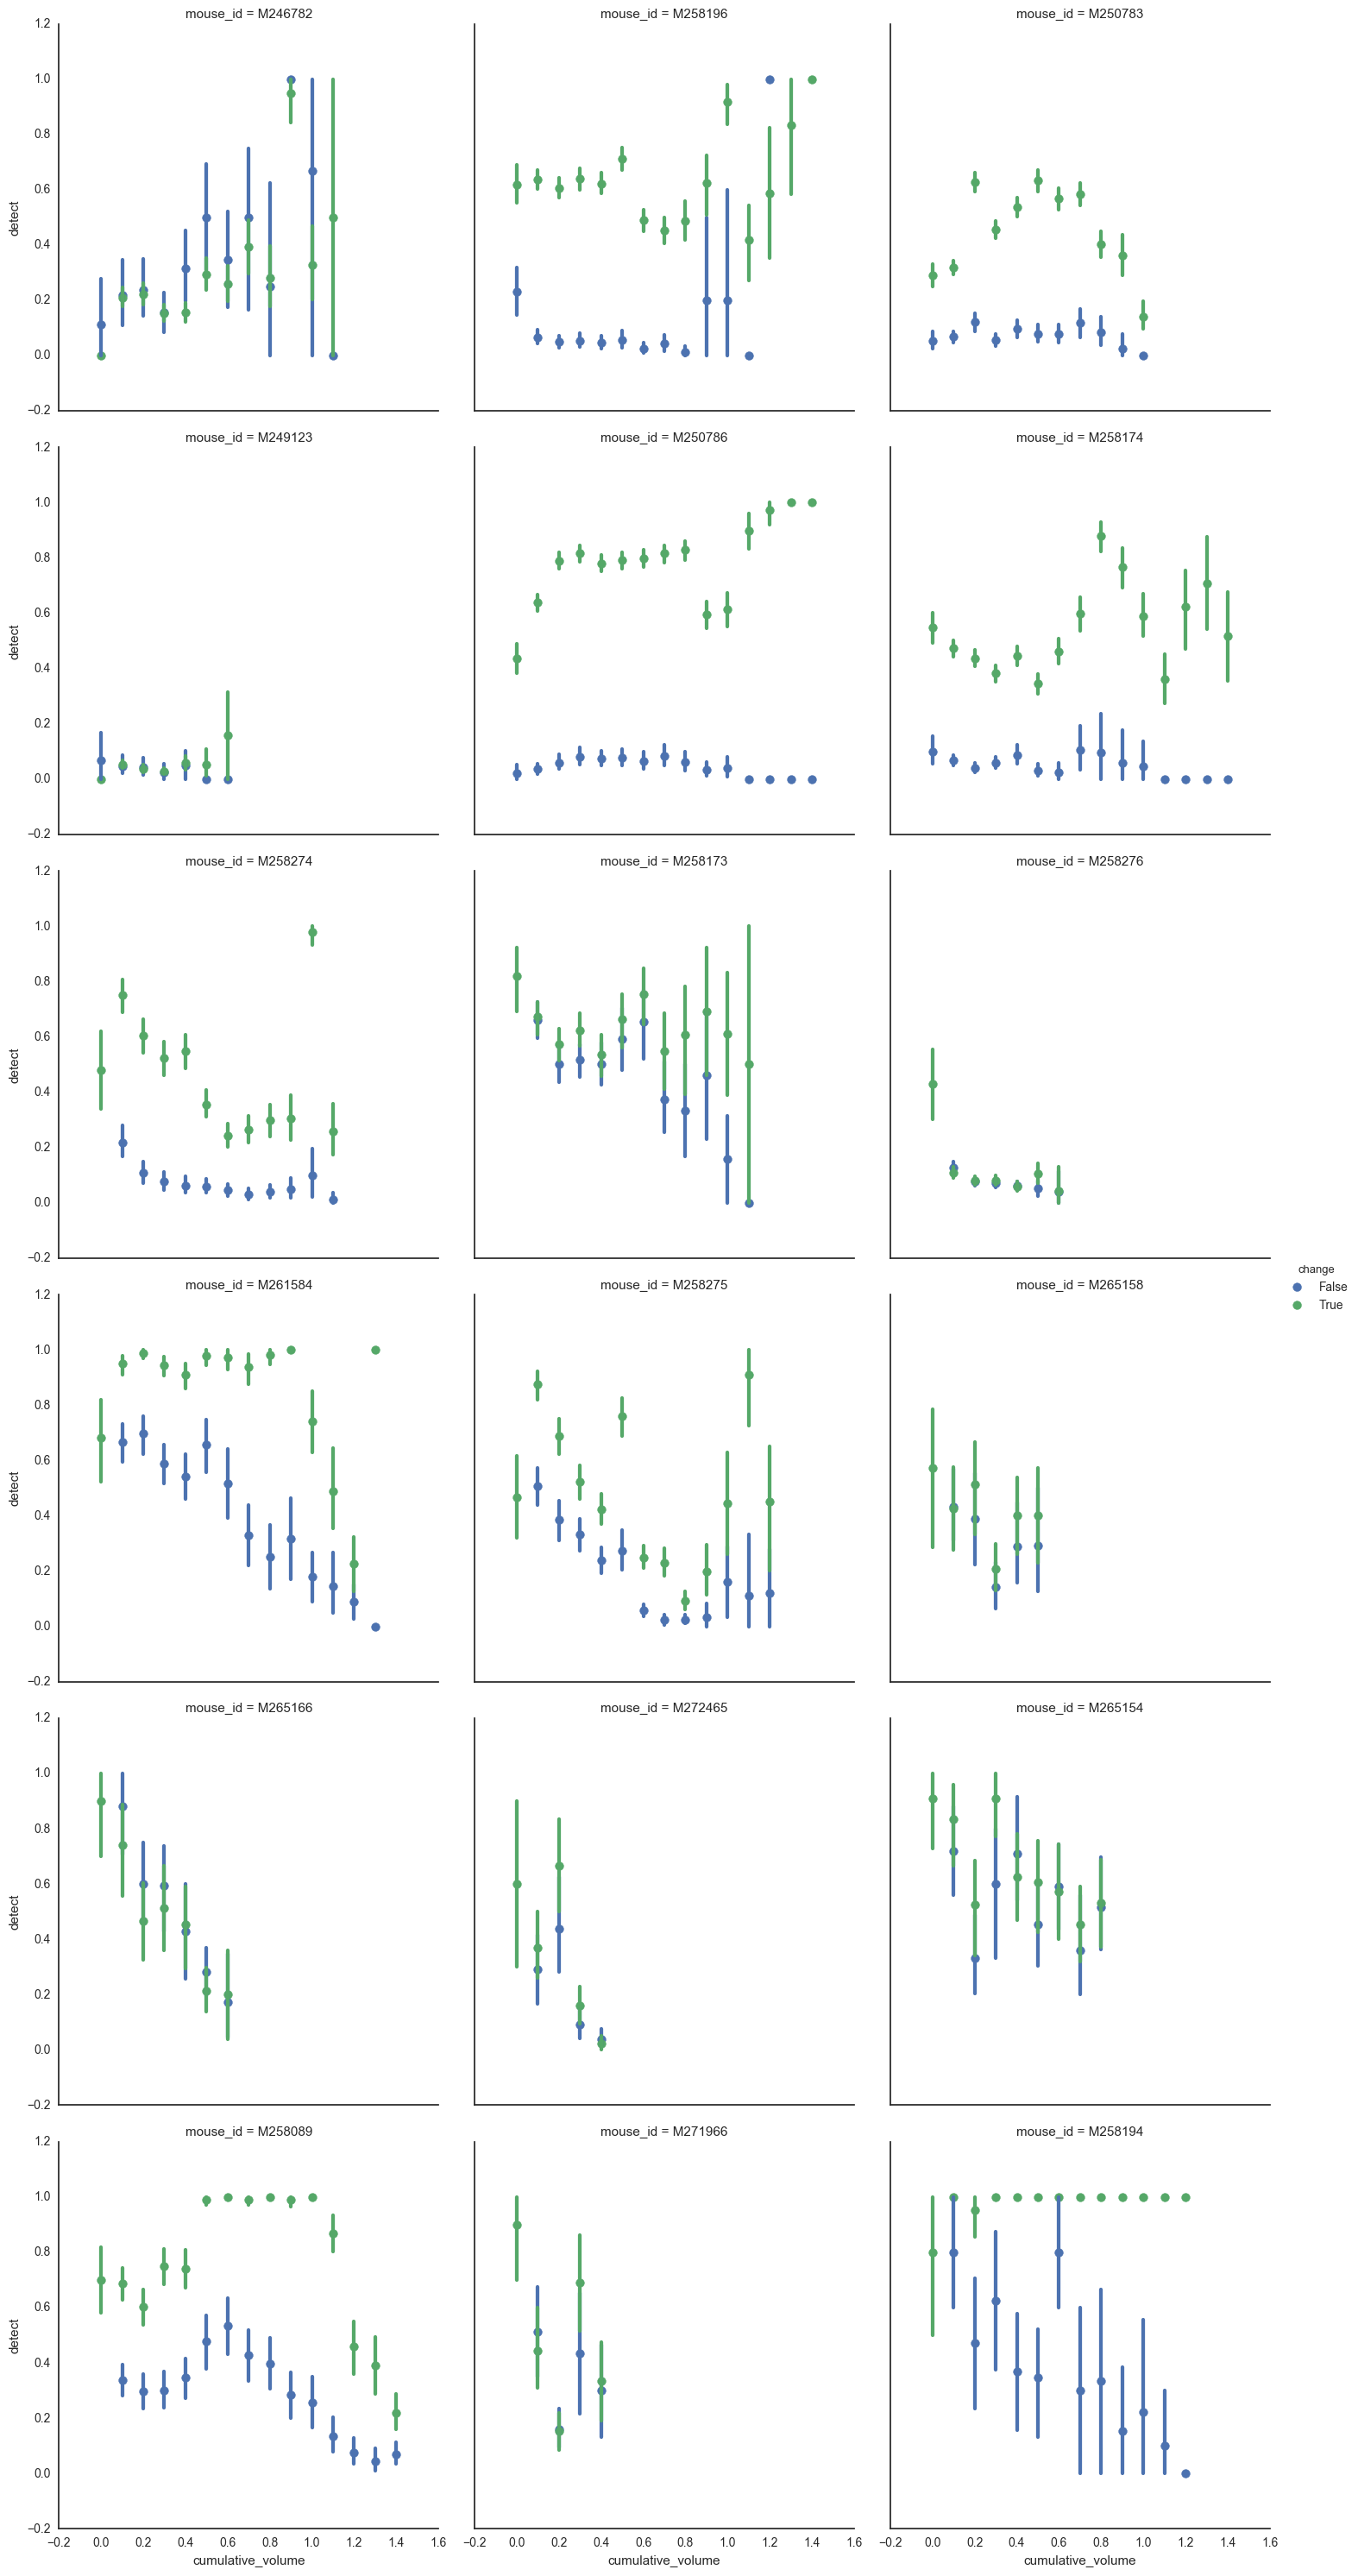

In [156]:
data = df[
#     (df.mouse_id==good_mouse)
    df.trial_type.isin(('go','catch'))
    & (df.training_day ==6)
]

sns.lmplot('cumulative_volume','detect',
           data=data,
#            logistic=True,
           hue='change',
           col='mouse_id',
           col_wrap=3,
           x_bins=np.arange(0,df.cumulative_volume.max(),0.1),
           fit_reg=False,
)
# plt.xlim(0,3)

In [25]:
df['success'] = (df['trial_type']=='go') & (df['detect'])
df['failure'] = (df['trial_type']!='go') & (df['detect'])

In [26]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [27]:
from patsy import dmatrices
from sklearn import linear_model

In [148]:
df.dayofweek.unique()

array([0, 3, 4, 1, 2], dtype=int64)

In [147]:
df.columns

Index([u'LDT_mode', u'auto_rewarded', u'blank_screen_timeout', u'change_color',
       u'change_contrast', u'change_frame', u'change_image', u'change_ori',
       u'change_size', u'change_time', u'color', u'cumulative_volume', u'day',
       u'dayofweek', u'delta_ori', u'filename', u'filepath', u'hour', u'index',
       u'inital_color', u'inital_contrast', u'initial_contrast',
       u'initial_image', u'initial_ori', u'initial_size', u'lick_times',
       u'month', u'mouse_id', u'number_of_rewards', u'optogenetics',
       u'response', u'response_latency', u'response_time', u'response_type',
       u'response_window', u'reward_frames', u'reward_times', u'reward_volume',
       u'rewarded', u'scheduled_change_time', u'startdatetime', u'startframe',
       u'starttime', u'stim_on_frames', u'trial_length', u'trial_type',
       u'year', u'cohort', u'date', u'training_day', u'day_of_week', u'change',
       u'detect', u'reaction_time', u'response_window_lower',
       u'response_window_upp

In [174]:
def compute_strategy(behav_df):
    
    df = behav_df.copy(deep=True)
    
    for factor in ('success','failure'):
        df['prior_{}'.format(factor)] = (
            df[factor]
            .rolling(center=False,window=2)
            .apply(func=lambda x: x[0]==True)
            )
    
    predictors = [
        'prior_success',
        'prior_failure',
        'orientation_delta',
        'cumulative_volume',
#         'time_since_last_water_log',
#         'hour',
        
    ]
    
    df = df[['detect',]+predictors].dropna().apply(pd.to_numeric)
    df['detect'] = df['detect'].astype(int)
    
    # z-score the predictors
    for col in predictors:
        df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)

    #train logistic regression
    formula = 'detect ~ ' + ' + '.join(predictors)
    y, X = dmatrices(formula,df)
    
    try:
        # fit
#         glm = smf.glm(formula=formula,data=df,family=sm.families.Binomial()).fit()
#         # return weights
#         params = glm.params
#         pv = glm.pvalues
#         pv = pv.rename({s: s+'_p' for s in pv.index})
        
#         params = pd.concat([params,pv]).rename('params')
        logreg = linear_model.LogisticRegression(
#             Cs=np.logspace(-6,6,10),
            penalty = 'l2',
            class_weight = 'balanced',
        )
        logreg.fit(X,y)
#         print logreg.C_
#         print logreg.coef_.shape
#         print zip(['Intercept',]+predictors,logreg.coef_.tolist())
#         print X.design_info
        results = {k:v for k,v in zip(X.design_info.column_names,logreg.coef_[0])}
        results.update(dict(
#             C=logreg.C_,
            score=logreg.score(X,y)
            )
        )
#         print results
        
        return pd.Series(results,name='results')
    
    
    except Exception:
        return None

In [175]:
results = compute_strategy(df)
print results

Intercept           -0.029047
cumulative_volume    0.037994
orientation_delta    0.547623
prior_failure        0.021175
prior_success        0.008093
score                0.555980
Name: results, dtype: float64


In [176]:
strategy = (
    df[df.trial_type.isin(['go','catch'])]
    .groupby(['cohort','mouse_id','training_day'])
    .apply(compute_strategy)
    .reset_index()
    )
strategy.head()

,cohort,mouse_id,training_day,Intercept,cumulative_volume,orientation_delta,prior_failure,prior_success,score
0,Cohort 1,M246782,1,-0.179937,-0.559917,-0.205102,0.208154,0.818281,0.752161
1,Cohort 1,M246782,2,-0.058751,0.341075,-0.410780,0.440676,0.312563,0.685714
2,Cohort 1,M246782,3,-0.152228,1.022459,-0.085357,0.154392,0.086277,0.678571
3,Cohort 1,M246782,4,-0.005669,-0.136675,-0.168906,-0.053359,0.059540,0.567073
4,Cohort 1,M246782,5,-0.018286,0.226381,0.007079,-0.404901,0.035330,0.533333


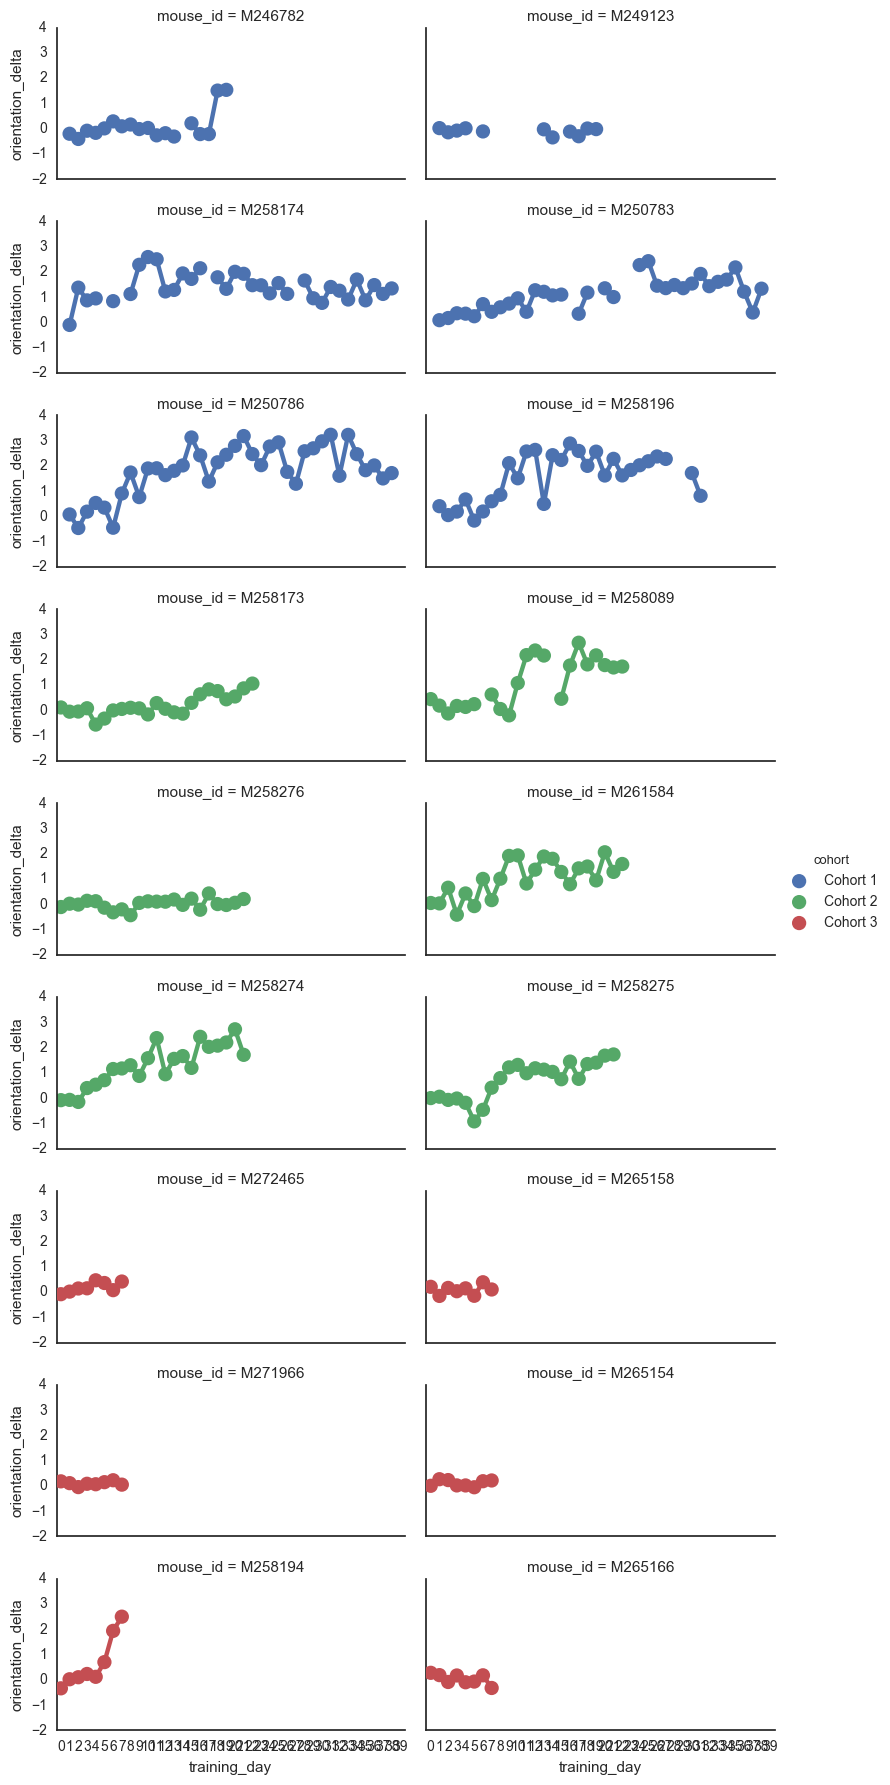

In [177]:
col_order = cohort['Cohort 1'] + cohort['Cohort 2'] + cohort['Cohort 3']

fp = sns.factorplot('training_day','orientation_delta',data=strategy,
                    col='mouse_id',
                    col_wrap=2,
                    size=2,
                    aspect=2,
                    hue='cohort',
                    col_order=col_order,
              )

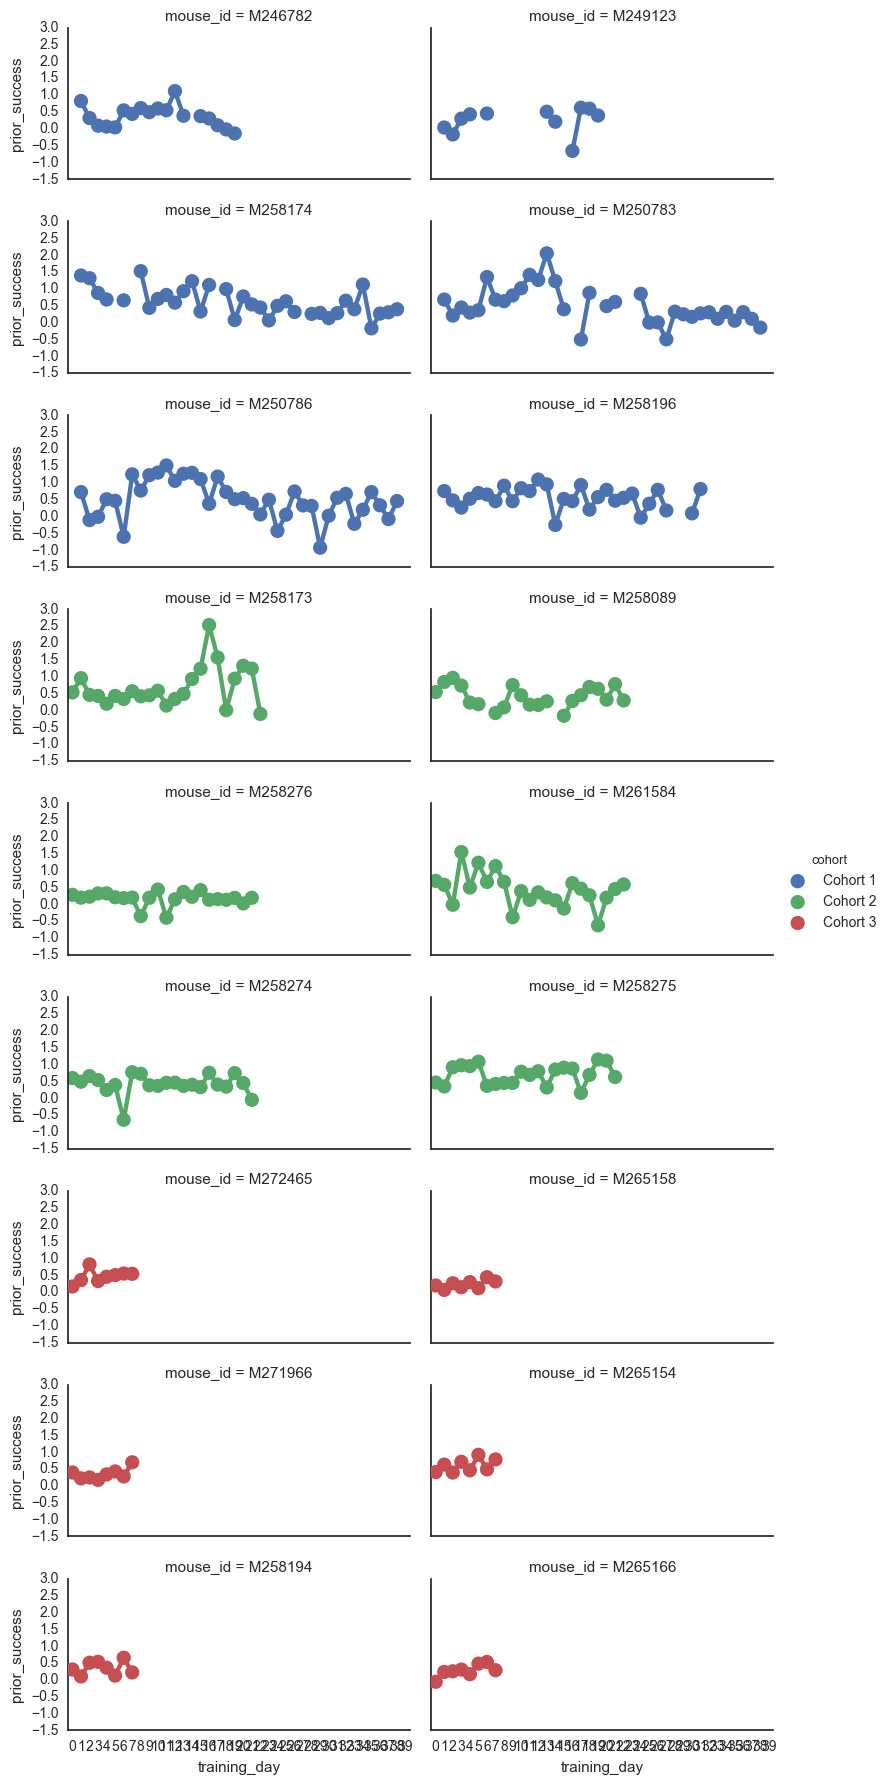

In [178]:
fp = sns.factorplot('training_day','prior_success',data=strategy,
                    col='mouse_id',
                    col_wrap=2,
                    size=2,
                    aspect=2,
                    hue='cohort',
                    col_order=col_order,
              )

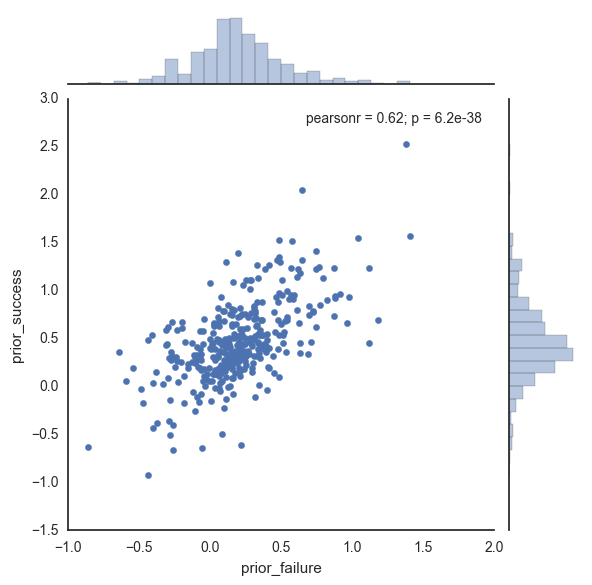

In [179]:
sns.jointplot('prior_failure','prior_success',data=strategy)

In [104]:
strategy['at_least_one'] = strategy.apply(lambda row: (row[['prior_success_p','prior_failure_p','orientation_delta_p']]<0.05).any(),axis=1)

In [180]:
strategy = pd.merge(water,strategy,on=['mouse_id','training_day'])

In [181]:
strategy['stimulus_control'] = strategy['discrim_p'] < 0.05

In [182]:
mask = (
#     (strategy['prior_failure'].abs()<10)
#     & (strategy['prior_success'].abs()<10)
#     & (strategy['orientation_delta'].abs()<10)
    (strategy['stimulus_control'])
)

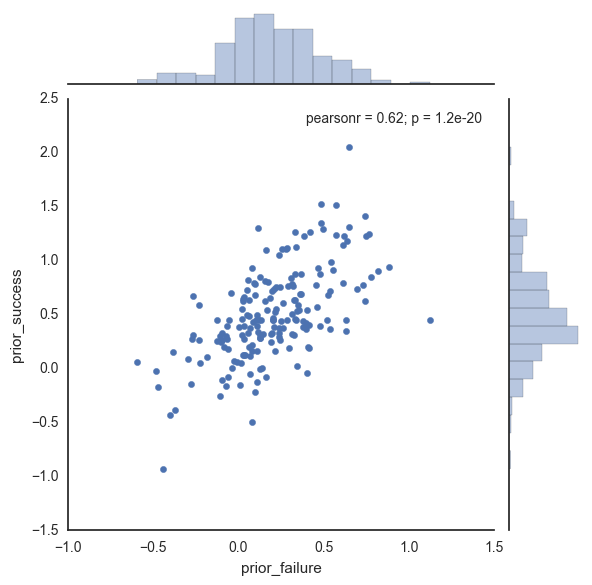

In [183]:
sns.jointplot('prior_failure','prior_success',data=strategy[mask])

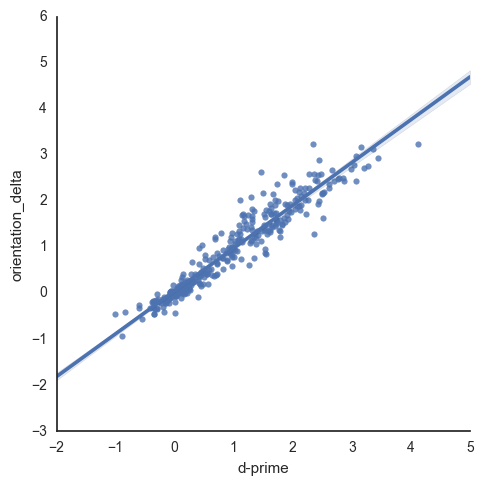

In [184]:
sns.lmplot('d-prime','orientation_delta',data=strategy,
#               hue='mouse_id',
              )

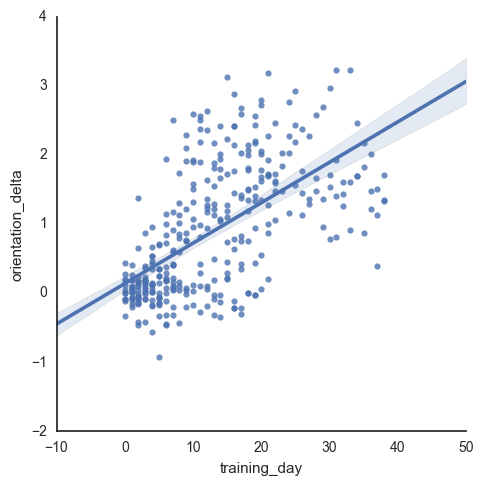

In [185]:
sns.lmplot('training_day','orientation_delta',data=strategy,
#               hue='mouse_id',
#            fit_reg=False,
              )

In [189]:
strategy

metrics,cohort_x,mouse_id,training_day,d-prime,discrim_p,earned_water,num_trials,reaction_time_05th%ile,reaction_time_50th%ile,reaction_time_95th%ile,...,d_prime,stimulus_control,criteria,cohort_y,Intercept,cumulative_volume,orientation_delta,prior_failure,prior_success,score
0,Cohort 1,M246782,1,-0.103298,0.932565,0.306,1563.0,0.148093,1.302331,4.174820,...,-0.103298,False,False,Cohort 1,-0.179937,-0.559917,-0.205102,0.208154,0.818281,0.752161
1,Cohort 1,M246782,2,-0.847842,0.060912,0.132,394.0,0.202361,1.369161,5.315562,...,-0.847842,False,False,Cohort 1,-0.058751,0.341075,-0.410780,0.440676,0.312563,0.685714
2,Cohort 1,M246782,3,-0.042514,0.814292,0.174,426.0,0.078129,1.488042,4.514744,...,-0.042514,False,False,Cohort 1,-0.152228,1.022459,-0.085357,0.154392,0.086277,0.678571
3,Cohort 1,M246782,4,-0.360547,0.499528,0.390,423.0,0.172509,1.553026,4.649878,...,-0.360547,False,False,Cohort 1,-0.005669,-0.136675,-0.168906,-0.053359,0.059540,0.567073
4,Cohort 1,M246782,5,0.116042,0.850189,0.470,423.0,0.099503,1.285357,4.209601,...,0.116042,False,False,Cohort 1,-0.018286,0.226381,0.007079,-0.404901,0.035330,0.533333
5,Cohort 1,M246782,6,0.394931,0.404005,0.430,417.0,0.197628,1.368870,4.283506,...,0.394931,False,False,Cohort 1,-0.066675,-0.197203,0.284788,-0.407034,0.540690,0.728205
6,Cohort 1,M246782,7,0.131160,0.989472,0.210,413.0,0.218248,1.710491,4.437584,...,0.131160,False,False,Cohort 1,-0.149855,-0.584607,0.089863,-0.313715,0.434616,0.704167
7,Cohort 1,M246782,8,0.453368,0.586696,0.300,421.0,0.150747,1.669237,5.115014,...,0.453368,False,False,Cohort 1,-0.111693,-0.231077,0.161087,-0.197970,0.608469,0.778986
8,Cohort 1,M246782,9,-0.307570,0.633583,0.170,410.0,0.257899,1.802267,4.039470,...,-0.307570,False,False,Cohort 1,-0.147218,-0.664747,-0.019534,-0.436503,0.485657,0.703349
9,Cohort 1,M246782,10,0.119426,0.961350,0.180,417.0,0.144039,1.093671,4.011087,...,0.119426,False,False,Cohort 1,-0.352926,-1.102535,0.024337,0.234604,0.595483,0.796380


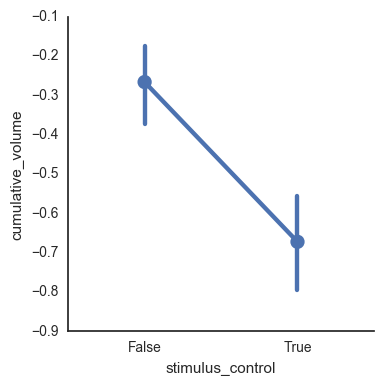

In [195]:
sns.factorplot('stimulus_control','cumulative_volume',data=strategy,
#               hue='mouse_id',
#            fit_reg=False,
#            x_bins=range(40),
#            col='mouse_id',
#            col_wrap=3,
              )
# plt.xlim(-1,df['training_day'].max())
# plt.ylim(-5,5)

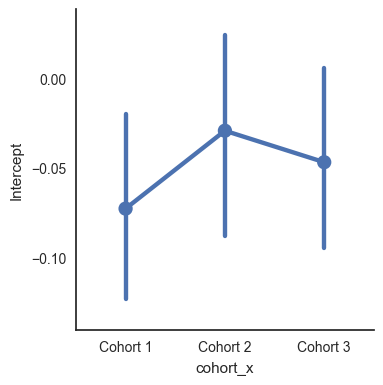

In [198]:
sns.factorplot('cohort_x','Intercept',data=strategy)